# PCA with a linear Autoencoder

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

Let's create same sin+noise signal as in the SVD notebook earlier.
You can experiment with the noise level or with the signal itself. Try making the signal fit into the buffer perfectly or have it fluctuate in phase. This can be done by changing f0 from 200 to 220.


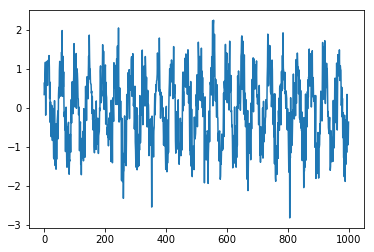

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fs = 10000
f0 = 220 #200 #220
T = 10
Ns = fs*T
s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)
n = np.random.randn(Ns)
x = s + 0.5*n 

# See Exercise description below
# s2 = sin(2*pi*3.5*f0*arange(Ns)/fs)
# x = s + s2 + 0.3*n

plt.plot(x[:1000])

from scipy.io import wavfile
wavfile.write('out1.wav', fs, x)

In [3]:
from numpy.linalg import svd

def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T


xmat = buffer(x,fs,400,200)
print(np.shape(xmat))

(400, 498)


Here we create an AE with 2 or more hidden layers. The input layers are the frames of the buffer.
See how sensitive it is to learning rate. 
Try setting n_hidden = 3 when the fundamental frequency f0 is not matching the buffer length (f0 = 220 for example)

In [4]:
import tensorflow as tf

n_inputs = np.shape(xmat)[0]
n_hidden = 3  # codings
n_outputs = n_inputs

learning_rate = 0.01 #0.05 #0.1

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
W = tf.Variable(tf.truncated_normal(stddev=.1, shape =[n_inputs,n_hidden]))

hidden = tf.matmul(X,W)
outputs = tf.matmul(hidden,tf.transpose(W))

#Alternative way to program this (will not expose W)
#hidden = tf.layers.dense(X, n_hidden)
#outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
#reconstruction_loss = tf.reduce_mean(tf.reduce_sum((outputs - X)*(outputs - X),1))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()


Here we run the optimization loop that updates the weights W, so they learn a sinusoid. We observe the learning process by plotting W every 500 interations.

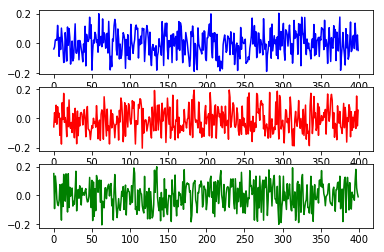

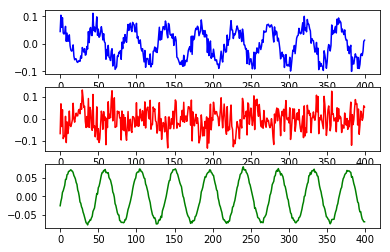

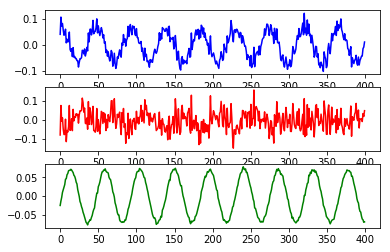

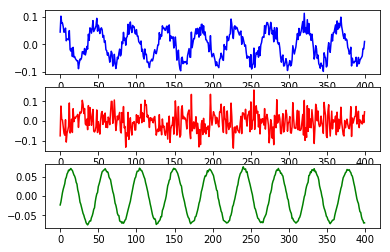

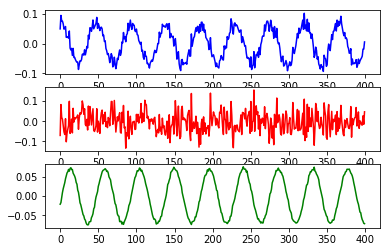

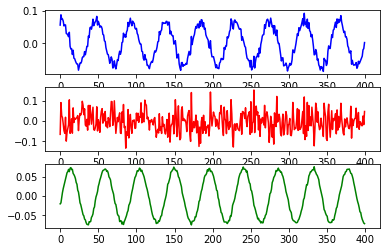

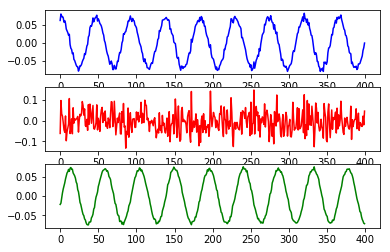

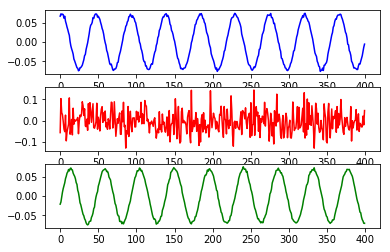

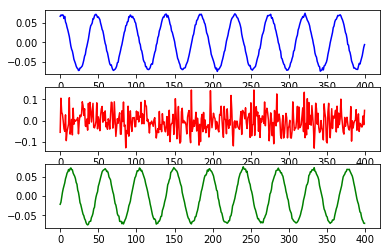

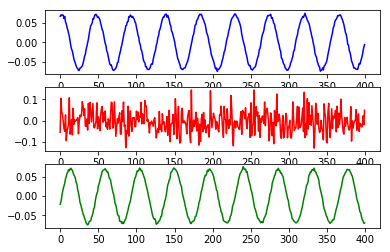

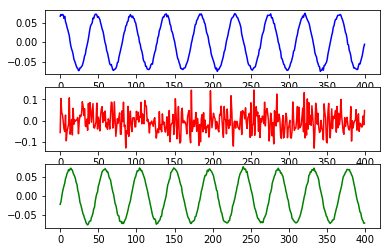

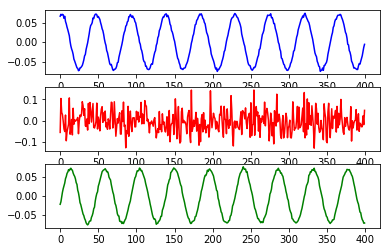

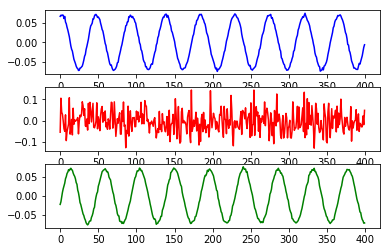

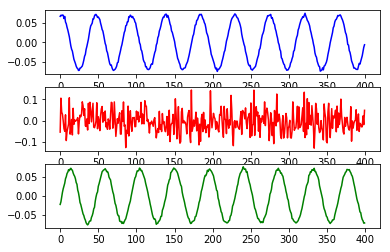

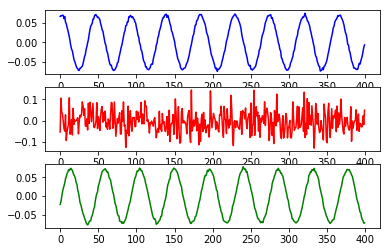

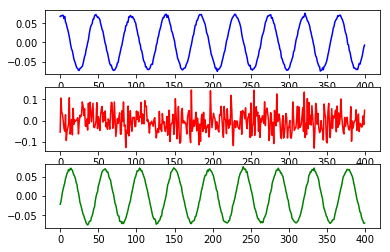

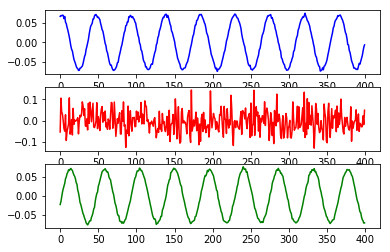

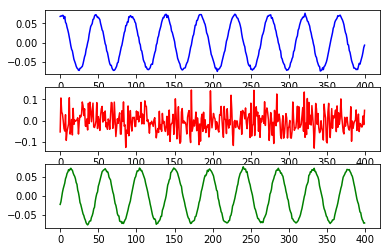

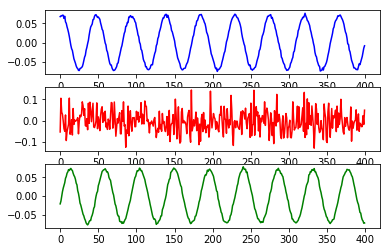

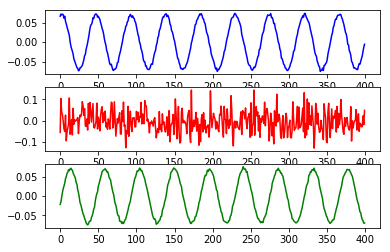

Done with training


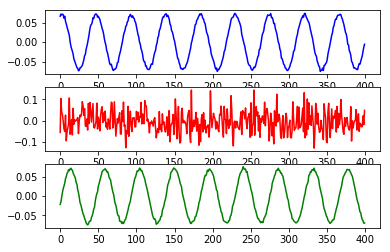

In [5]:
n_iterations = 10000
codings = hidden
X_train = xmat.T
X_test = X_train

col = ['b','r','g']

sess = tf.InteractiveSession()
init.run()
    
for iteration in range(n_iterations):
    training_op.run(feed_dict={X: X_train})

    if iteration %500 == 0:
        W_val = W.eval()
        plt.clf()
        for k in range(n_hidden):
            plt.subplot(n_hidden,1,k+1)
            plt.plot(W_val[:,k],col[k])
        
        plt.show(False)
        plt.pause(0.001)

codings_val = codings.eval(feed_dict={X: X_test})

print "Done with training"
    

We can examing now the "codings", i.e. the hidden unit values and their distribution. The more signigicant codings should have smaller variances.

mean:  [-0.00161049  0.0582127   0.01249221]
variance [ 10.03971004   0.95011854   9.94734383]


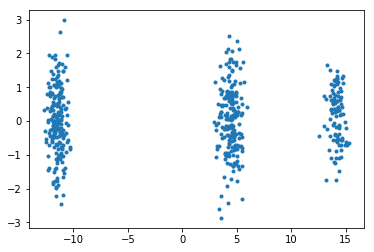

In [6]:
# print np.shape(codings_val)
plt.plot(codings_val[:,0],codings_val[:,1],'.')
print "mean: ", np.mean(codings_val,0)
print "variance", np.std(codings_val,0)

Trying to recreate the output from activating hidden units generates the corresponding signals as encoded in the weights.

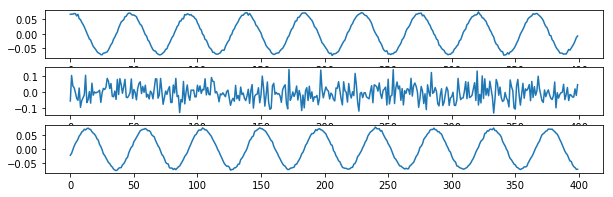

In [7]:
#X_out = outputs.eval(feed_dict={hidden: [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]})
X_out = outputs.eval(feed_dict={hidden: [[1,0,0],[0,1,0],[0,0,1]]})

plt.figure(figsize=(10, n_hidden))
for i in range(n_hidden):
    plt.subplot(n_hidden,1,i+1)
    plt.plot(X_out[i].T)